In [24]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [25]:
#import data
train = pd.read_csv('../../data/raw/Emergent_NAACL2016/emergent/url-versions-2015-06-14-clean.csv')
train.drop(columns=["Unnamed: 0"], inplace=True)

In [26]:
#create features
align_feature = pd.read_csv('../../data/processed/features/alignment_feature.csv')
cosine_feature = pd.read_csv('../../data/processed/features/cosine_feature.csv')
bow_feature = pd.read_csv('../../data/processed/features/headline_BoWBigram.csv')
qmark_feature = pd.read_csv('../../data/processed/features/headline_Qmark.csv')
neg_alignment_feature = pd.read_csv('../../data/processed/features/neg_alignment_feature.csv')
root_dist_feature = pd.read_csv('../../data/processed/features/root_dist_min.csv')
svo_feature = pd.read_csv('../../data/processed/features/svo_Lexical.csv')

In [27]:
target_map = {"for": 0, "observing": 1, "against": 2}

In [28]:
train = train.replace({"articleHeadlineStance": target_map})

In [29]:
train["articleHeadlineStance"].value_counts()

0    1238
1     962
2     395
Name: articleHeadlineStance, dtype: int64

In [30]:
train = pd.merge(train, align_feature, on="articleId")
train = pd.merge(train, cosine_feature, on="articleId")
train = pd.merge(train, bow_feature, on="articleId")
train = pd.merge(train, qmark_feature, on="articleId")
train = pd.merge(train, neg_alignment_feature, on="articleId")
train = pd.merge(train, root_dist_feature, on="articleId")
train = pd.merge(train, svo_feature, on="articleId")

In [31]:
train["articleHeadlineStance"] = train["articleHeadlineStance"].astype("int")

In [32]:
# merge datasets and shuuffle with random seed
seed = 1234

train = sklearn.utils.shuffle(train, random_state=seed)



In [33]:
# create train.
X_train = train.to_numpy()[:,5:]
Y_train = train["articleHeadlineStance"].values.reshape((-1,))

In [34]:
Y_train = Y_train
X_train = X_train.astype(float)

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

# Import some data to play with
X = X_train
y = Y_train

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

In [36]:
max_iter = 10e2
C=0.8
penalty='l1'

# Normal Train and Test

from sklearn.linear_model import LogisticRegression


In [37]:
# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)
# Learn to predict each class against the other
classifier = OneVsRestClassifier(LogisticRegression(penalty=penalty, C=C, max_iter = max_iter, multi_class='auto', solver="liblinear"))


In [38]:
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

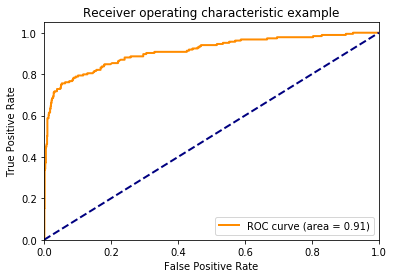

In [39]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

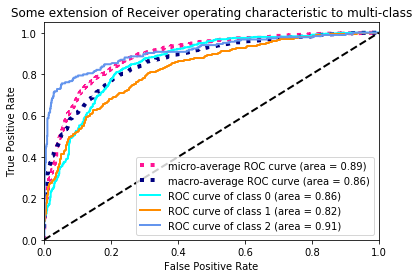

In [41]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()